# XZZX threshold vs bias

The XZZX surface code introduced in [Bonilla Atiades, Tuckett, Bartlett, Flammia and Brown 2021](https://arxiv.org/abs/2009.07851) is a Clifford-deformed variant of the 2D surface code with an ultra-high threshold error rate for Pauli noise under high bias. In fact, it has a 50% threshold for infinitely biased noise (_i.e._ dephasing).
In this tutorial, we explore how to use PanQEC to compute the threshold error rates of the XZZX surface code and the CSS surface code under Pauli noise of different values of bias.
The goal is to produce a plot of the threshold physical error rate vs the Pauli channel $Z$ bias for both the CSS surface code and the XZZX surface code for their performance to be compared.

## Control experiment: CSS surface code

The CSS toric code is found in PanQEC as the class [panqec.codes.Toric2DCode](/codes.html#panqec.codes.surface_2d.Toric2DCode).

In [1]:
code_input = {
    'name': 'Toric2DCode',
    'parameters': [
        {'L_x': 6},
        {'L_x': 12},
        {'L_x': 24}
    ]
}

As before we use the Matching Decoder.

In [2]:
decoder_input = {
    'name': 'MatchingDecoder',
    'parameters': [{}]
}

A one-qubit Pauli channel takes the form
$$\mathcal{E}(\rho)  = (1 - p) \rho + p (r_X X \rho X + r_Y Y \rho Y + r_z Z \rho Z)$$
where $p$ is the physical error rate and $r_X, r_Y, r_Z\in [0, 1]$ are parameters such that  $r_X + r_Y + r_Z=1$.
Physically, this means that when this channel is applied on a qubit,
with probably $p$ an error will occur,
which could be either Pauli $X,Y,Z$ with probability $r_X,r_Y,r_Z$.
This error model is included in PanQEC as [panqec.error_models.PauliErrorModel](/error_models.html#panqec.error_models.PauliErrorModel).

The _bias_ of a channel is the ratio
$$\eta_Z = \frac{r_Z}{r_X + r_Y}$$
For a depolarizing channel $\eta_Z=0.5$ and for a dephasing channel $\eta_Z=\infty$.
For this tutorial,
we will assume that $r_X=r_Y=(1-r_Z)/2$ so then
$$r_Z = 2r_X \eta_Z = (1 - r_Z)\eta_Z = \eta_Z - r_Z \eta_Z$$
and hence
$$r_Z = \frac{\eta_Z}{1 + \eta_Z}$$
It takes just some simple algebra to calculate $r_X,r_Y,r_Z$ given $\eta_Z$.
Luckily there is a utility function that can calculate exactly this and return it in dictionary format,
which can be read as input parameters for the `error_model` attribute in the input file.

In [3]:
from panqec.utils import get_direction_from_bias_ratio
get_direction_from_bias_ratio('Z', 10)

{'r_x': 0.04545454545454547,
 'r_y': 0.04545454545454547,
 'r_z': 0.9090909090909091}

However, we want more than just a single value of $\eta_Z$.
We want to generate inputs for many values of $\eta_Z$,
noting that the thresholds should change.
This could be obtained by trial and error,
but let's try the following ranges:

In [4]:
css_error_rate_ranges = [
    {'eta': 0.5, 'min': 0.1, 'max': 0.2},
    {'eta': 10, 'min': 0.05, 'max': 0.15},
    {'eta': 30, 'min': 0.05, 'max': 0.15},
]

We can then generate the input ranges using the following

In [5]:
import numpy as np
css_inputs = [
    {
        'label': 'CSS surface code eta = ' + str(entry['eta']),
        'code': code_input,
        'error_model': {
            'name': 'PauliErrorModel',
            'parameters': get_direction_from_bias_ratio('Z', entry['eta']),
        },
        'decoder': decoder_input,
        'error_rate': np.linspace(entry['min'], entry['max'], 5).tolist(),
    }
    for entry in css_error_rate_ranges
]

css_inputs

[{'label': 'CSS surface code eta = 0.5',
  'code': {'name': 'Toric2DCode',
   'parameters': [{'L_x': 6}, {'L_x': 12}, {'L_x': 24}]},
  'error_model': {'name': 'PauliErrorModel',
   'parameters': {'r_x': 0.33333333333333337,
    'r_y': 0.33333333333333337,
    'r_z': 0.3333333333333333}},
  'decoder': {'name': 'MatchingDecoder', 'parameters': [{}]},
  'error_rate': [0.1, 0.125, 0.15000000000000002, 0.17500000000000002, 0.2]},
 {'label': 'CSS surface code eta = 10',
  'code': {'name': 'Toric2DCode',
   'parameters': [{'L_x': 6}, {'L_x': 12}, {'L_x': 24}]},
  'error_model': {'name': 'PauliErrorModel',
   'parameters': {'r_x': 0.04545454545454547,
    'r_y': 0.04545454545454547,
    'r_z': 0.9090909090909091}},
  'decoder': {'name': 'MatchingDecoder', 'parameters': [{}]},
  'error_rate': [0.05, 0.075, 0.1, 0.125, 0.15]},
 {'label': 'CSS surface code eta = 30',
  'code': {'name': 'Toric2DCode',
   'parameters': [{'L_x': 6}, {'L_x': 12}, {'L_x': 24}]},
  'error_model': {'name': 'PauliErrorMo

When using the matching decoder, we have already shown how to use PanQEC to compute the threshold error rate for the CSS toric code under biased noise in the previous tutorial
[Computing the threshold of the surface code](/tutorials/Computing%20threshold.html).

The results from the above inputs will serve as the control for our experiment.

## XZZX surface code

Since we already have a working decoder and CSS code,
it is convenient to not to have to rewrite the decoder and code when studying the Clifford-deformed XZZX code,
which is merely related to the CSS surface code by a Hadamard on every qubit along a particular axis.

As such, to simplify the simulations and reuse the existing code and decoder,
instead of deforming the code,
we can deform the noise model,
which will give equivalent statistics.
Luckily in the PanQEC,
deformations of codes can be specified in the class definition of the code itself.
We can view what deformations are available for the code.

In [6]:
from panqec.codes import Toric2DCode
Toric2DCode.deformation_names

['XZZX', 'XY']

We can see that we have two deformations implemented,
namely the XZZX deformation and the XY deformation ([Tuckett, Bartlett and Flammia 2017](https://arxiv.org/abs/1708.08474)).
We can tell PanQEC to use the XZZX deformation on the noise model based on the deformation in the code class by specifying the `deformation_name` parameter explicitly in the `parameters` of the `error_model`.
For example, if we wanted to simulate the XZZX code under unbiased depolarizing noise,
we would use the following input dictionary:
```
{
    ...
    'code': {
        'name': 'Toric2DCode', 
        'parameters': [{'L_x': 6}, {'L_x': 12}, {'L_x': 24}]
    },
    'error_model': {
        'name': 'PauliErrorModel',  # Class name of the error model
        'parameters': [
            {'r_x': 1/3, 'r_y': 1/3, 'r_z': 1/3, 'deformation_name': 'XZZX'}
        ],
    },
    ...
}
```
We can similarly generate inputs for the XZZX surface code.

Note that in Python one can expand dictionaries using the `**` operator:

In [7]:
{'a': 1, 'b': 2, **{'c': 3}}

{'a': 1, 'b': 2, 'c': 3}

We can now similarly generate the inputs for the XZZX surface code using the below ranges (from trial and error):

In [8]:
xzzx_error_rate_ranges = [
    {'eta': 0.5, 'min': 0.1, 'max': 0.2},
    {'eta': 10, 'min': 0.20, 'max': 0.35},
    {'eta': 30, 'min': 0.25, 'max': 0.4},
]

In [9]:
xzzx_inputs = [
    {
        'label': 'XZZX surface code eta = ' + str(entry['eta']),
        'code': code_input,
        'error_model': {
            'name': 'PauliErrorModel',
            'parameters': {
                **get_direction_from_bias_ratio('Z', entry['eta']),
                'deformation_name': 'XZZX',
            },
        },
        'decoder': decoder_input,
        'error_rate': np.linspace(entry['min'], entry['max'], 8).tolist(),
    }
    for entry in xzzx_error_rate_ranges
]

xzzx_inputs

[{'label': 'XZZX surface code eta = 0.5',
  'code': {'name': 'Toric2DCode',
   'parameters': [{'L_x': 6}, {'L_x': 12}, {'L_x': 24}]},
  'error_model': {'name': 'PauliErrorModel',
   'parameters': {'r_x': 0.33333333333333337,
    'r_y': 0.33333333333333337,
    'r_z': 0.3333333333333333,
    'deformation_name': 'XZZX'}},
  'decoder': {'name': 'MatchingDecoder', 'parameters': [{}]},
  'error_rate': [0.1,
   0.1142857142857143,
   0.1285714285714286,
   0.14285714285714285,
   0.15714285714285714,
   0.17142857142857143,
   0.18571428571428572,
   0.2]},
 {'label': 'XZZX surface code eta = 10',
  'code': {'name': 'Toric2DCode',
   'parameters': [{'L_x': 6}, {'L_x': 12}, {'L_x': 24}]},
  'error_model': {'name': 'PauliErrorModel',
   'parameters': {'r_x': 0.04545454545454547,
    'r_y': 0.04545454545454547,
    'r_z': 0.9090909090909091,
    'deformation_name': 'XZZX'}},
  'decoder': {'name': 'MatchingDecoder', 'parameters': [{}]},
  'error_rate': [0.2,
   0.22142857142857145,
   0.24285714

## Running the simulations

We can now combine everything into one input dictionary just for this tutorial,
though in practice it may be your preference to split them up and run them in parallel.

In [10]:
input_data = {
    'ranges': css_inputs + xzzx_inputs
}

input_data

{'ranges': [{'label': 'CSS surface code eta = 0.5',
   'code': {'name': 'Toric2DCode',
    'parameters': [{'L_x': 6}, {'L_x': 12}, {'L_x': 24}]},
   'error_model': {'name': 'PauliErrorModel',
    'parameters': {'r_x': 0.33333333333333337,
     'r_y': 0.33333333333333337,
     'r_z': 0.3333333333333333}},
   'decoder': {'name': 'MatchingDecoder', 'parameters': [{}]},
   'error_rate': [0.1, 0.125, 0.15000000000000002, 0.17500000000000002, 0.2]},
  {'label': 'CSS surface code eta = 10',
   'code': {'name': 'Toric2DCode',
    'parameters': [{'L_x': 6}, {'L_x': 12}, {'L_x': 24}]},
   'error_model': {'name': 'PauliErrorModel',
    'parameters': {'r_x': 0.04545454545454547,
     'r_y': 0.04545454545454547,
     'r_z': 0.9090909090909091}},
   'decoder': {'name': 'MatchingDecoder', 'parameters': [{}]},
   'error_rate': [0.05, 0.075, 0.1, 0.125, 0.15]},
  {'label': 'CSS surface code eta = 30',
   'code': {'name': 'Toric2DCode',
    'parameters': [{'L_x': 6}, {'L_x': 12}, {'L_x': 24}]},
   'erro

We are now ready to create a simulation as before by reading the input dictionary.

In [11]:
from panqec.simulation import read_input_dict

n_trials = 200  # Target number of Monte Carlo runs

# We create a BatchSimulation by reading the input dictionary
batch_sim = read_input_dict(
    input_data,
    output_file='xzzx-css-2d-results.json'
)

Start batch simulation instance


This time, instead of live plotting,
we will just stick with the good old tqdm progress bar.

In [12]:
from tqdm import tqdm
batch_sim.run(n_trials, progress=tqdm)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.20it/s]


## Analyzing results

Once we are done collecting the simulation data,
we can read it in by creating an `Analysis` object.

In [13]:
from panqec.analysis import Analysis

analysis = Analysis("xzzx-css-2d-results.json")
analysis.calculate_thresholds()
analysis.calculate_sector_thresholds()

## Making plots

And now we can make plots showing the data collapse in the calculation of the threshold error rate for each code deformation and bias. As you could tell by looking at the plots, we didn't take very much data so the results are very rough since we used very few Monte Carlo samples, but they do give a rough estimate to improve the ranges of error rate to use for the input. For a more serious experiment, we would do a few more runs to pin down an appropriate range of physical error rates to run before committing to larger-sized simulations that take much longer.

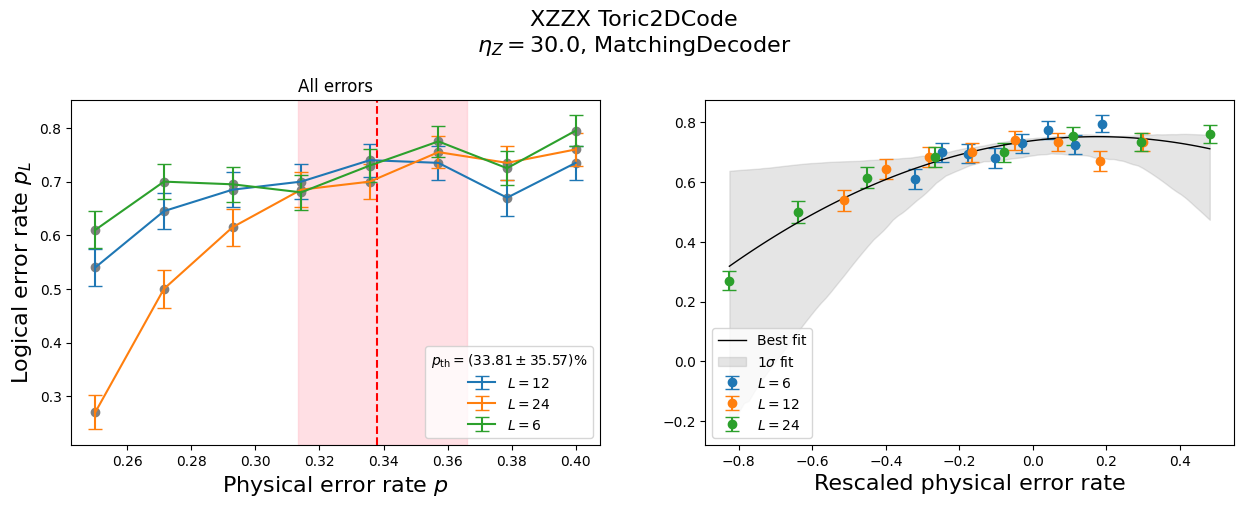

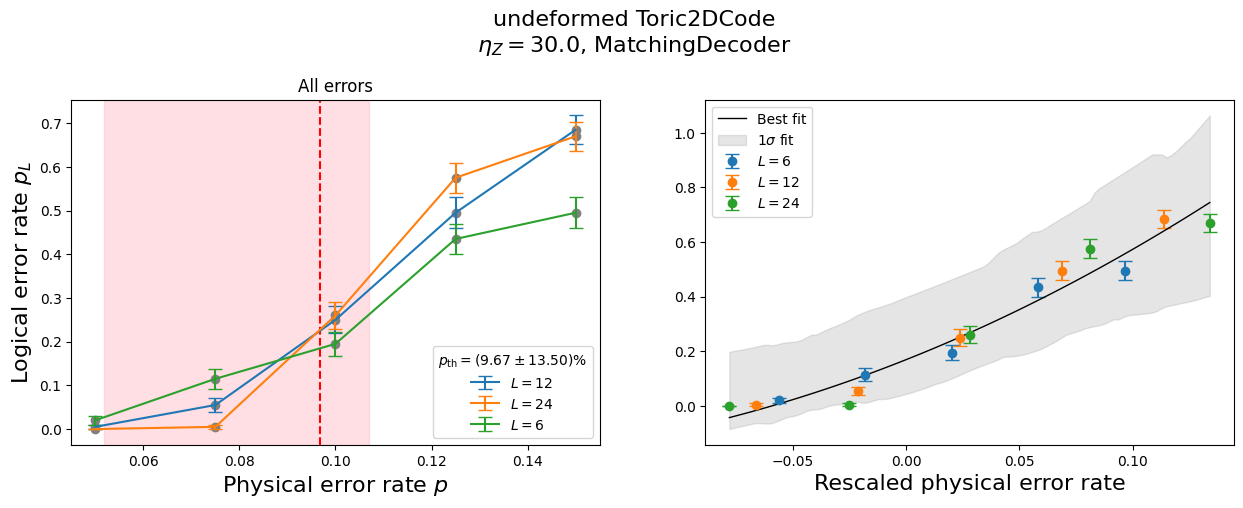

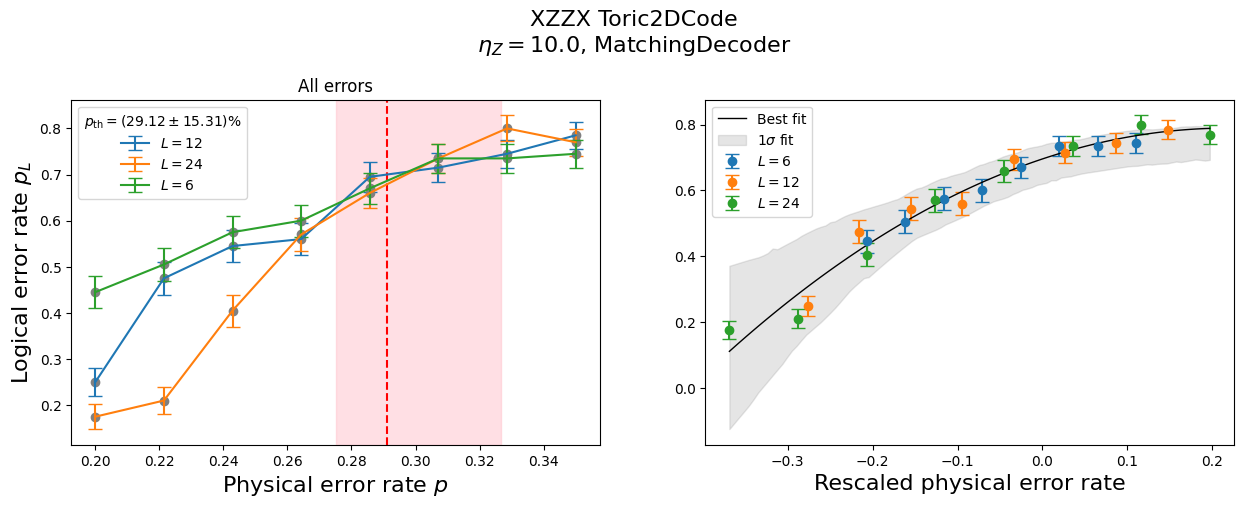

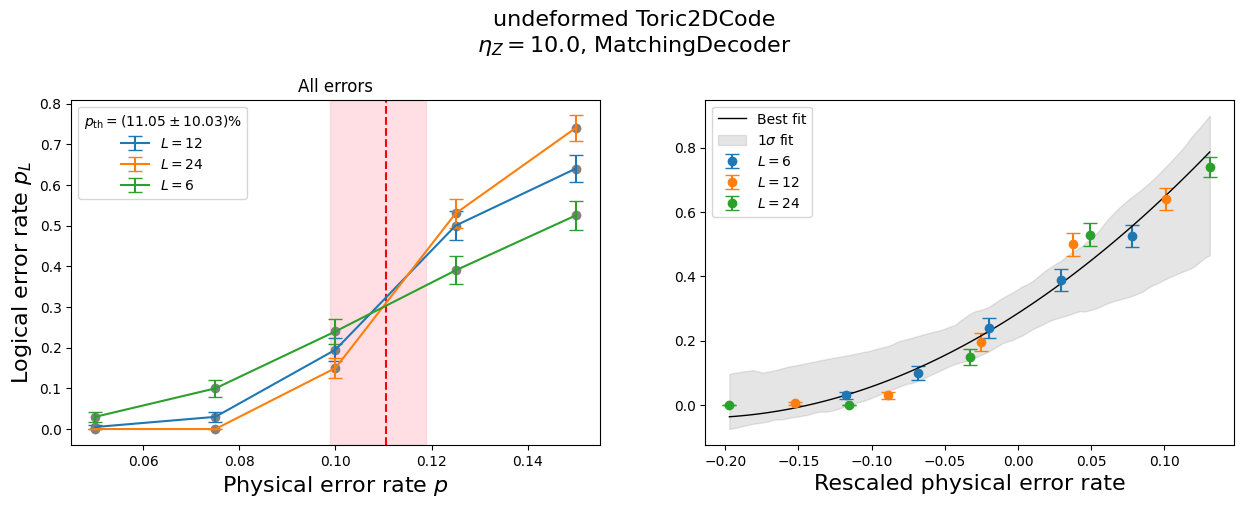

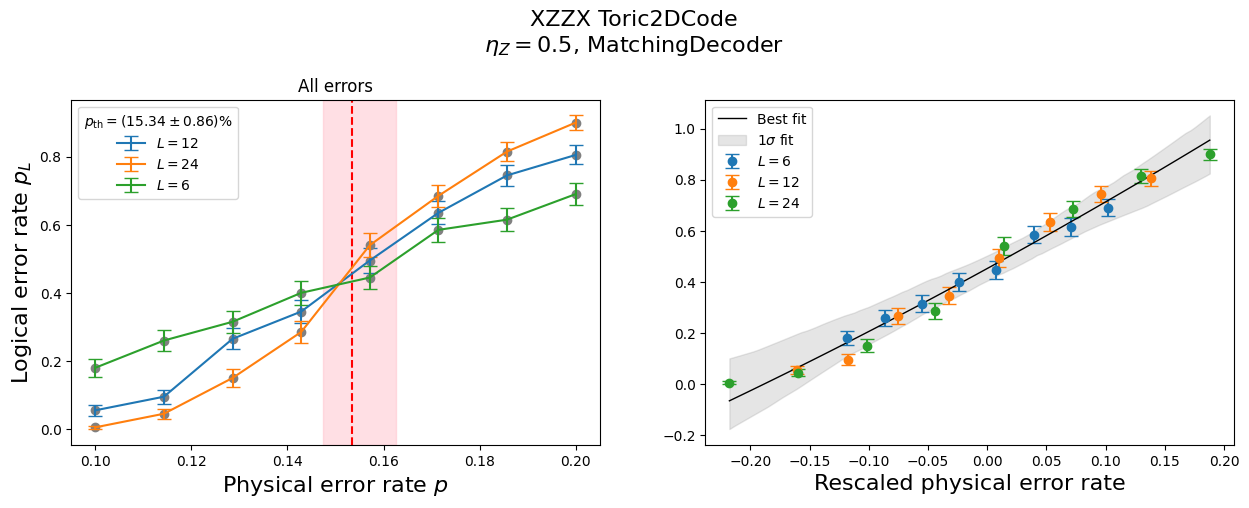

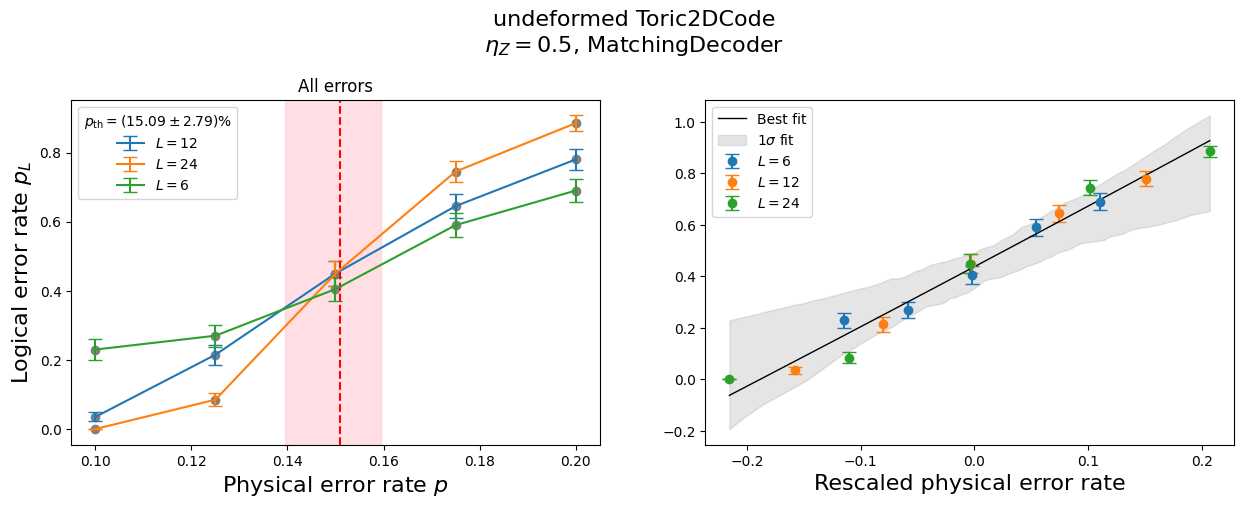

In [14]:
analysis.make_collapse_plots(sector='total')

Finally, we can plot the threshold error rate $p_{\textrm{th}}$ over the bias $\eta_Z$ for each code.

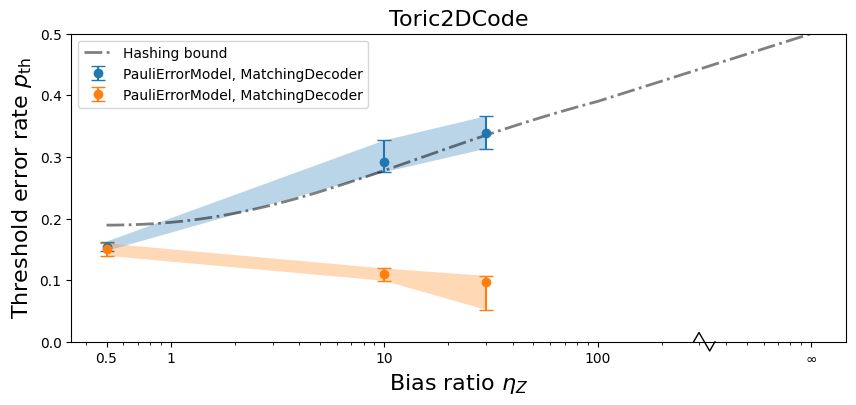

In [15]:
analysis.make_threshold_vs_bias_plots()

We see that the XZZX surface code outperforms the CSS surface code in terms of threshold error rate for high bias.

Further explorations would involve testing out other codes, error models, decoders, using larger simulations, etc.